In [1]:
import math
import numpy as np

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
%matplotlib inline

import tensorflow as tf
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Num GPUs Available:  1


In [2]:
print(tf.__version__)

2.1.0


In [3]:
def load_horses_orig(path, image_size):
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images = []
    test_masks = []
    
    for i in range(328):
        
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)
        
        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0
        
        images.append(low_im)
        masks.append(bin_mask)
    
    xtest = np.reshape(np.array(images[250:]), (-1,image_size, image_size, 3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size, image_size, 1))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size, image_size, 3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size, image_size, 1))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size, image_size, 1))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size, image_size, 3))
    return xdata, xval, xtest, ydata, yval, ytest

In [4]:
#change the path address 
path = './horses/'
image_size = 32
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

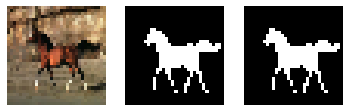

(32, 32, 3) (32, 32, 1)


In [5]:
def draw(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size,3)))
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

def draw_all(image, real_mask, fake_mask):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(image)
    ax2.imshow(real_mask, cmap=plt.cm.gray)
    ax3.imshow(fake_mask, cmap=plt.cm.gray)
    plt.show()
    
draw_all(xdata[0], ydata[0], ydata[0])
print(xdata[0].shape, ydata[0].shape)

In [6]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt))
    union = np.sum(np.maximum(yp, yt))
    return np.average(intersect / (union+0.0))

In [7]:
assert iou(ydata, ydata) == 1.0

# CNN GAN

In [8]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.concat_layer = tf.keras.layers.Concatenate(axis=3)
        
        self.conv1 = tf.keras.layers.Conv2D(1, 3, 2, activation = tf.nn.softplus)
        self.conv2 = tf.keras.layers.Conv2D(32, 3, 2, activation = tf.nn.softplus)
        self.conv3 = tf.keras.layers.Conv2D(64, 3, 2, activation = tf.nn.softplus)
        self.conv4 = tf.keras.layers.Conv2D(128, 3, 2, activation = tf.nn.softplus)
        
        self.flatten = tf.keras.layers.Flatten()
        self.fc_score = tf.keras.layers.Dense(1)

    def call(self, x, yt, y):
        x = tf.cast(x, tf.float32)
        yt = tf.cast(yt, tf.float32)
        y = tf.cast(y, tf.float32)

        x = self.concat_layer([x, yt, y])
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc_score(x)
        return x

class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.concat_layer = tf.keras.layers.Concatenate(axis=3)
        self.conv1 = tf.keras.layers.Conv2DTranspose(128, 3, 2, activation = tf.nn.softplus, padding = 'same')
        self.conv2 = tf.keras.layers.Conv2DTranspose(64, 3, 2, activation = tf.nn.softplus, padding = 'same')
        self.conv3 = tf.keras.layers.Conv2DTranspose(32, 3, 2, activation = tf.nn.softplus, padding = 'same')
        self.conv4 = tf.keras.layers.Conv2DTranspose(1, 3, 2, activation = tf.nn.softplus, padding = 'same')
        
        self.flatten = tf.keras.layers.Flatten()
        self.fc_energy = tf.keras.layers.Dense(1)
        
        
    def call(self, x, z):
        x = tf.cast(x, tf.float32)
        x = self.concat_layer([x, z])
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc_energy(x)
        return x

# Unrolled Inference

In [9]:
def compute_gradient(x, y):
    y = tf.Variable(y)
    with tf.GradientTape() as t:
        t.watch(y)
        energy = gen(x, y)
    return t.gradient(energy, y)

def unrolled_inf(images, fake_label, inf_iter, inf_rate):
    yp_ind = fake_label;    y_start = yp_ind;     current_yp_ind = y_start
    
    yp_ar = []
    for i in range(inf_iter):
        gradients = compute_gradient(images, yp_ind)
        
        next_yp_ind = tf.math.add(current_yp_ind, tf.math.multiply(inf_rate, gradients))
        
        # Langevin dynamics
        temp = tf.cast(inf_rate/2, tf.float32)
        temp = temp * gradients + tf.random.normal(gradients.get_shape().as_list(), mean=0, stddev=inf_rate)
        next_yp_ind = next_yp_ind + temp
        current_yp_ind = next_yp_ind
        
        yp_ind = current_yp_ind
        yp_ar.append(yp_ind)
        
    yp = yp_ar[-1]
    yp = tf.nn.sigmoid(yp)
    return yp

# Visualization

In [10]:
def plot_figure(loss, arange, brange, start, end, step, plot_name):
    axis_length = len(np.linspace(start, end, step))
    loss = loss.numpy().reshape(-1, axis_length)

    # plot the surface plot with plotly's Surface
    fig = go.Figure(data=go.Surface(z=loss,
                                    x=arange,
                                    y=brange))

    # add a countour plot
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))

    # annotate the plot
    fig.update_layout(title=plot_name,
                      scene=dict(
                        xaxis_title='Pred. Label Axis-0',
                        yaxis_title='Pred. Label Axis-1',
                        zaxis_title=plot_name),
                      width=700, height=700)

    fig.show()
    
def generate_vectors(real_image, real_label, fake_label, start, end, step):
    arange = np.linspace(start, end, step)
    brange = np.linspace(start, end, step)

    alen = arange.shape[0]
    blen = brange.shape[0]

    r1 = np.random.uniform(0, 1, (fake_label.shape[0], image_size * image_size))
    r1[:,0] = 1 - r1[:,1]
    r2 = np.random.uniform(0, 1, (fake_label.shape[0], image_size * image_size))
    r2[:,0] = 1 - r2[:,1]
    
    y_img = np.zeros((alen*blen, fake_label.shape[0], image_size * image_size * 3))
    y_pred = np.zeros((alen*blen, fake_label.shape[0], image_size * image_size))
    y_true = np.zeros((alen*blen, fake_label.shape[0], image_size * image_size))
    for b in range(0,blen):
        for a in range(0,alen):
            k = arange[a]
            l = brange[b]
            y_pred[b*alen+a] = tf.clip_by_value(fake_label[0, :] + l*r1[0, :] + k*r2[0, :], 0.0, 1.0) # just one horse
            y_true[b*alen+a] = real_label[0]
            y_img[b*alen+a] = real_image[0]
    return arange, brange, y_img, y_pred, y_true

def plot_contour_ce(real_image, real_label, inf_iter, inf_rate, start, end, step):
    batch_size = real_label.shape[0]
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
    fake_label = unrolled_inf(real_image, z, inf_iter, inf_rate)
    
    fake_label = np.array(fake_label).reshape(-1, image_size * image_size)
    real_label = np.array(real_label).reshape(-1, image_size * image_size)
    real_image = np.array(real_image).reshape(-1, image_size * image_size * 3)

    arange, brange, y_img, y_pred, y_true = generate_vectors(real_image, real_label, fake_label, start, end, step)

    # CE Loss
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    plot_figure(loss, arange, brange, start, end, step, 'Cross Entropy')
    
    
def plot_contour_adv(real_image, real_label, inf_iter, inf_rate, start, end, step):
    batch_size = real_label.shape[0]
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
    fake_label = unrolled_inf(real_image, z, inf_iter, inf_rate)
    
    fake_label = np.array(fake_label).reshape(-1, image_size * image_size)
    real_label = np.array(real_label).reshape(-1, image_size * image_size)
    real_image = np.array(real_image).reshape(-1, image_size * image_size * 3)
    
    # Adv loss
    arange, brange, y_img, y_pred, y_true = generate_vectors(real_image, real_label, fake_label, start, end, step)
    
    real_image = y_img.reshape(-1, image_size, image_size, 3)
    real_label = y_true.reshape(-1, image_size, image_size, 1)
    fake_label = y_pred.reshape(-1, image_size, image_size, 1)
    
    # disc signals
    real_score = dis(real_image, real_label, real_label)
    fake_score = dis(real_image, real_label, fake_label)

    # adv loss EBGAN
    margin = 10.0
    loss = real_score + tf.math.maximum(margin - fake_score, 0.0)
    plot_figure(loss, arange, brange, start, end, step, 'Adversarial loss')
    
    
def plot_hist(fake, real):
    fake = np.array(fake).reshape(-1, 1)
    real = np.array(real).reshape(-1, 1)
    bins = len(fake)
    plt.figure(figsize=(15,5))
    plt.hist(fake, bins, alpha=0.5, color='blue', label='Fake')
    plt.hist(real, bins, alpha=0.5, color='orange', label='Real')
    plt.legend(loc='upper right')
    plt.show()
    
def calc_iou(images, labels, inf_iter, inf_rate):
    batch_size = labels.shape[0]
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
    fake_label = unrolled_inf(images, z, inf_iter, inf_rate)
    return iou(labels, fake_label)

def draw_test(images, labels, inf_iter, inf_rate, name):
    batch_size = labels.shape[0]
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
    fake_label = unrolled_inf(images, z, inf_iter, inf_rate)
    iou_score = iou(labels, fake_label)
    print('\n' + name + ' iou_score %:', round(iou_score*100, 2))
    
    for i in range(10):
        draw_all(images[i], labels[i], fake_label[i])
        
def plot_iou(epoch, train_iou, val_iou, test_iou):
    plt.plot(np.arange(epoch+1), np.array(train_iou), label = "train")
    plt.plot(np.arange(epoch+1), np.array(val_iou), label = "test")
    plt.plot(np.arange(epoch+1), np.array(test_iou), label = "valid")
    plt.xlabel('Epoch')
    plt.ylabel('IOU Score')
    plt.legend()
    plt.show()

# Training Functions

In [11]:
def pullaway_loss(embeddings):
    batch_size = embeddings.get_shape().as_list()[0]
    norm = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    similarity = tf.linalg.matmul(normalized_embeddings, normalized_embeddings, transpose_b=True)
    batch_size = tf.cast(tf.shape(embeddings)[0], tf.float32)
    pt_loss = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return pt_loss

def train_step_gen(real_image, real_label, inf_iter, inf_rate, pt_loss, alpha):
    batch_size = real_image.get_shape().as_list()[0]
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
    real_label = tf.cast(real_label, dtype=tf.float32)
    with tf.GradientTape() as tape:
        fake_label = unrolled_inf(real_image, z, inf_iter, inf_rate)
        fake_score = dis(real_image, real_label, fake_label)
        PT_LOSS_WEIGHT = 0.1
        loss = tf.reduce_mean(fake_score) + PT_LOSS_WEIGHT * pullaway_loss(fake_label) + (pt_loss * alpha)
    gradients = tape.gradient(loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(gradients, gen.trainable_variables))
    gen_loss(loss)

def train_step_dis(real_image, real_label, inf_iter, inf_rate):
    batch_size = real_image.get_shape().as_list()[0]
    real_label = tf.cast(real_label, dtype=tf.float32)
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
        
    with tf.GradientTape() as tape:
        fake_label = unrolled_inf(real_image, z, inf_iter, inf_rate)
        real_score = dis(real_image, real_label, real_label)
        fake_score = dis(real_image, real_label, fake_label)
        
        # adv loss EBGAN
        margin = 10.0
        loss = tf.reduce_mean(real_score) + tf.math.maximum(margin - tf.reduce_mean(fake_score), 0.0)
    
    gradients = tape.gradient(loss, dis.trainable_variables)
    dis_opt.apply_gradients(zip(gradients, dis.trainable_variables))
    
    dis_loss(loss)
    adv_loss(loss)
    return fake_score, real_score
    
def pretrain_gen(real_image, real_label, inf_iter, inf_rate):
    batch_size = real_image.get_shape().as_list()[0]
    real_label = tf.cast(real_label, dtype=tf.float32)
    z = tf.random.uniform([batch_size, image_size, image_size, 1], 0.0, 1.0)
    with tf.GradientTape() as tape:
        fake_label = unrolled_inf(real_image, z, inf_iter, inf_rate)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_label, fake_label))
    gradients = tape.gradient(loss, gen.trainable_variables)
    gen_opt_pt.apply_gradients(zip(gradients, gen.trainable_variables))
    gen_pretrain_loss(loss)
    return loss

def train(data, n_epoch, n_update_dis, inf_iter, inf_rate, pt_gen, alpha):
    train_iou = []; val_iou = []; test_iou = [];
    for epoch in range(n_epoch):
        print('\nepoch:', epoch)
        
        if epoch == 0:
            pt_loss = 0
        
        fake_store = [];   real_store = [];
        for images, labels in train_dataset:
            
            # train gen
            if epoch > 0:
                if pt_gen:
                    pt_loss = pretrain_gen(images, labels, inf_iter, inf_rate)
                train_step_gen(images, labels, inf_iter, inf_rate, pt_loss, alpha)
            
            # train disc
            for i in range(n_update_dis):
                fake_sc, real_sc = train_step_dis(images, labels, inf_iter, inf_rate)
            
            fake_store.append(fake_sc.numpy())
            real_store.append(real_sc.numpy())
#             adv_store.append(advloss.numpy())
            
        # store iou progression
        train_iou.append(calc_iou(xdata, ydata, inf_iter, inf_rate))
        val_iou.append(calc_iou(xtest, ytest, inf_iter, inf_rate))
        test_iou.append(calc_iou(xval, yval, inf_iter, inf_rate))
        
        # plot adv
#         plt.plot(np.absolute(np.array(adv_store)))
#         plt.show()
        
        if epoch % 20 == 0:
            plot_hist(fake_store, real_store)
            
            start, end, step = 0.0, 20.0, 10
            plot_contour_ce(xtest, ytest, inf_iter, inf_rate, start, end, step)
            
            start, end, step = -200.0, 100.0, 10
            plot_contour_adv(xtest, ytest, inf_iter, inf_rate, start, end, step)

            draw_test(xdata, ydata, inf_iter, inf_rate, 'train')
            draw_test(xtest, ytest, inf_iter, inf_rate, 'test')
            draw_test(xval, yval, inf_iter, inf_rate, 'valid')
            
            plot_iou(epoch, train_iou, val_iou, test_iou)
                
        template = 'PT Gen Loss: {}, Gen Loss: {}, Dis Loss: {}, Adv Loss: {}'
        print (template.format(gen_pretrain_loss.result(), gen_loss.result(), dis_loss.result(), adv_loss.result()))
        dis_loss.reset_states()
        adv_loss.reset_states()
        gen_loss.reset_states()
        gen_pretrain_loss.reset_states()

# Deploy Network

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0

epoch: 0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0

Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


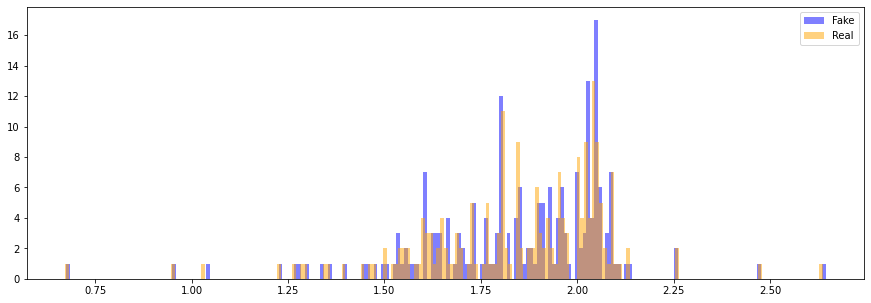

Executing op Minimum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Maximum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Log in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Neg in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0



train iou_score %: 21.32
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0


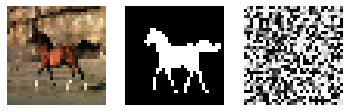

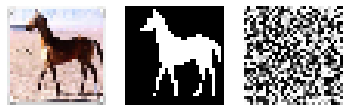

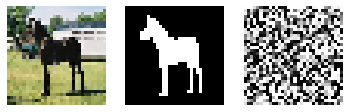

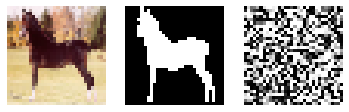

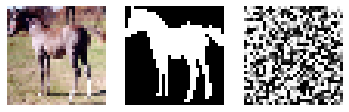

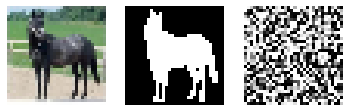

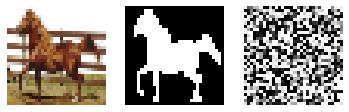

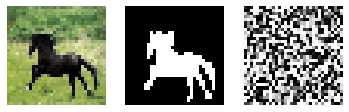

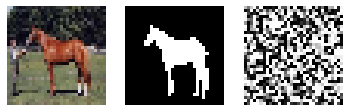

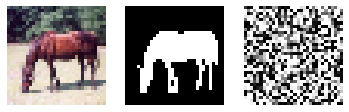


test iou_score %: 23.32


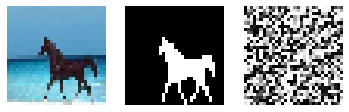

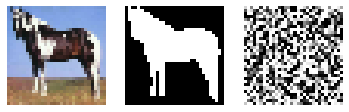

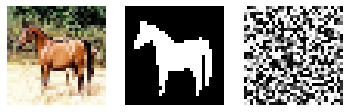

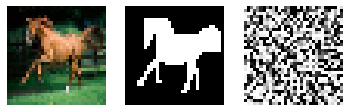

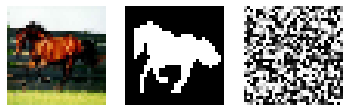

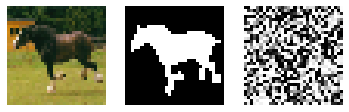

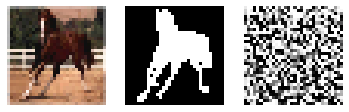

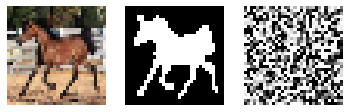

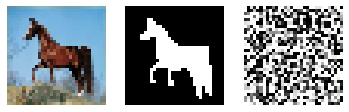

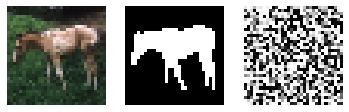


valid iou_score %: 23.09


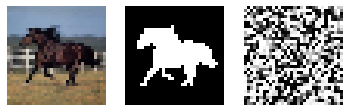

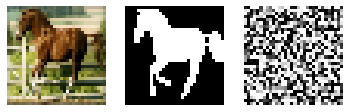

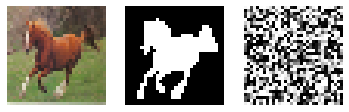

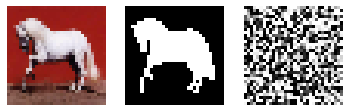

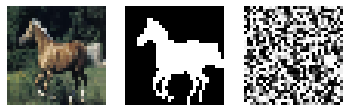

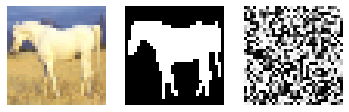

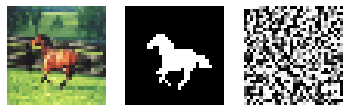

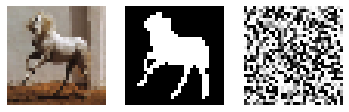

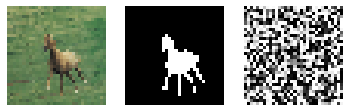

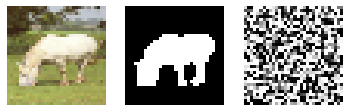

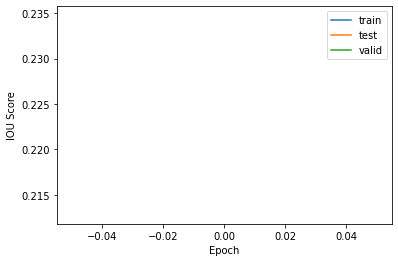

PT Gen Loss: 0.0, Gen Loss: 0.0, Dis Loss: 9.999576568603516, Adv Loss: 9.999576568603516

epoch: 1
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Minimum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Log in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BroadcastTo in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reciprocal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LessEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddN in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Square in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sum in device /job:localhost/

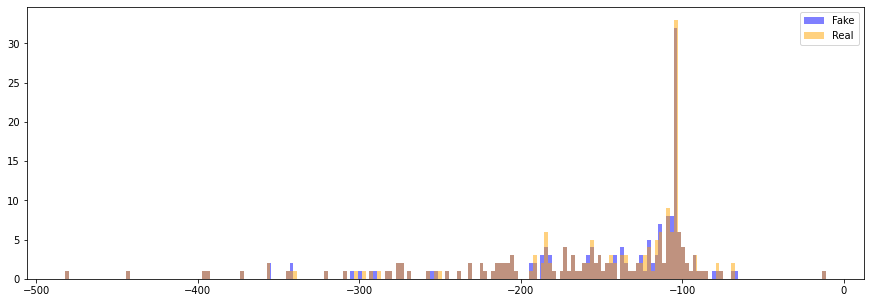


train iou_score %: 67.84


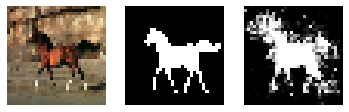

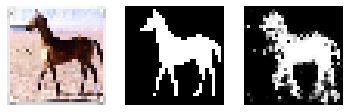

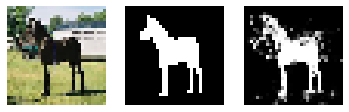

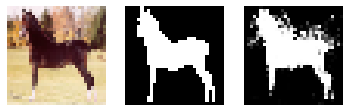

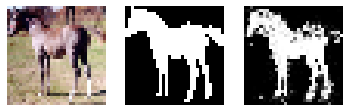

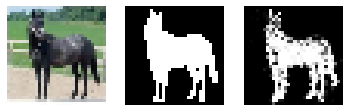

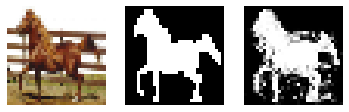

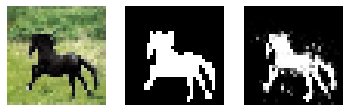

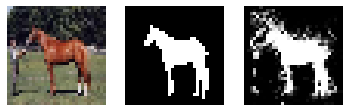

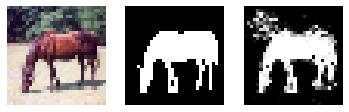


test iou_score %: 61.95


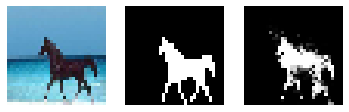

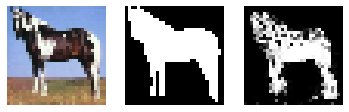

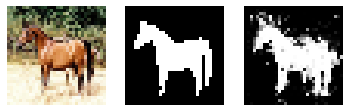

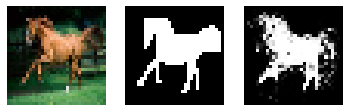

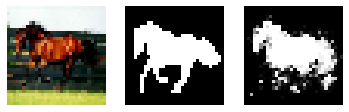

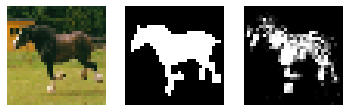

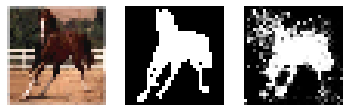

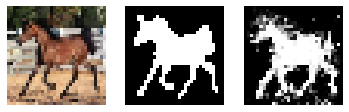

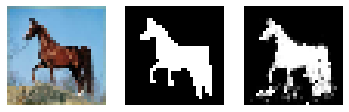

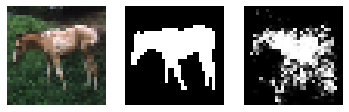


valid iou_score %: 57.35


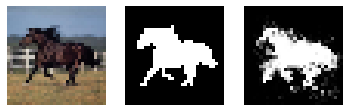

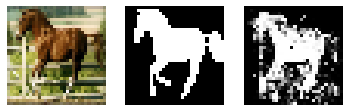

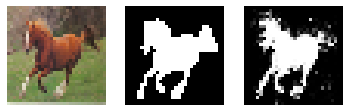

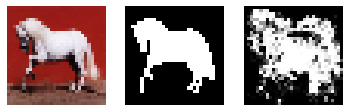

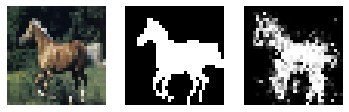

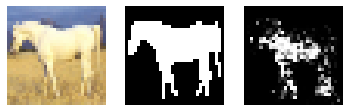

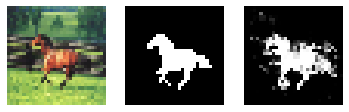

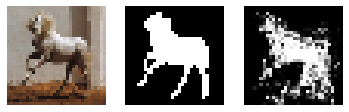

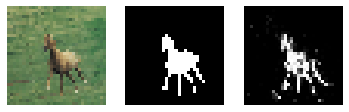

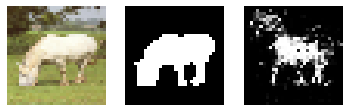

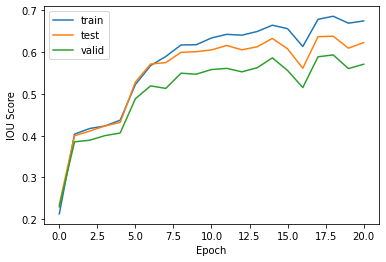

PT Gen Loss: 0.29904893040657043, Gen Loss: -154.42984008789062, Dis Loss: 10.067220687866211, Adv Loss: 10.067220687866211

epoch: 21
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.304923415184021, Gen Loss: -148.96615600585938, Dis Loss: 10.038890838623047, Adv Loss: 10.038890838623047

epoch: 22
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.27705830335617065, Gen Loss: -143.49427795410156, Dis Loss: 10.052007675170898, Adv Loss: 10.052007675170898

epoch: 23
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.2636816203594208, Gen Loss: -137.4249725341797, Dis Loss: 10.045968055725098, Adv Loss:

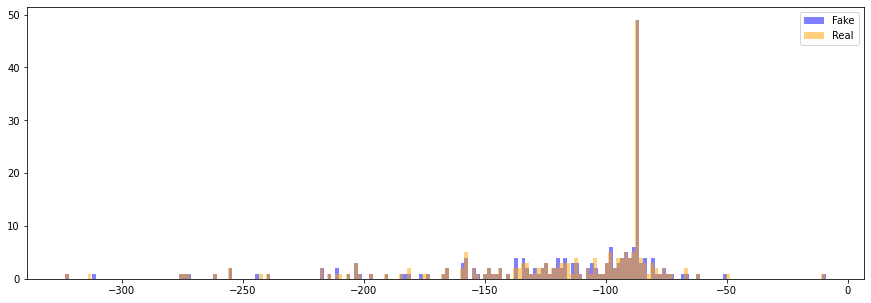


train iou_score %: 79.98


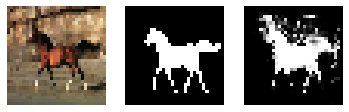

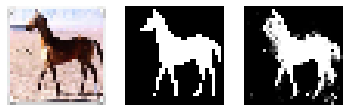

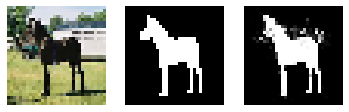

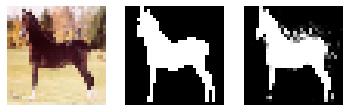

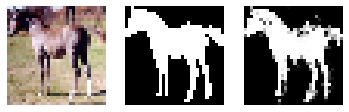

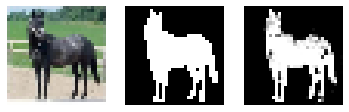

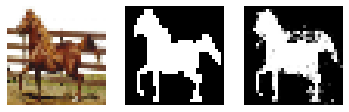

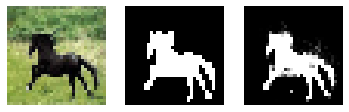

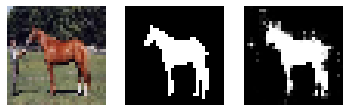

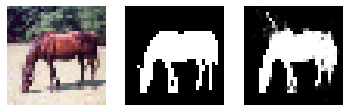


test iou_score %: 64.54


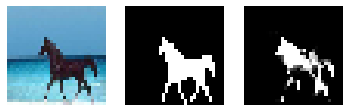

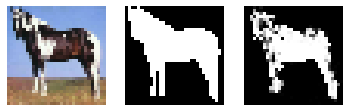

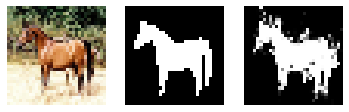

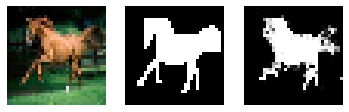

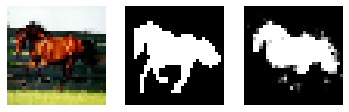

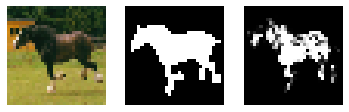

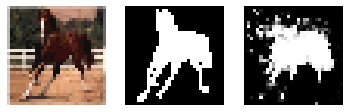

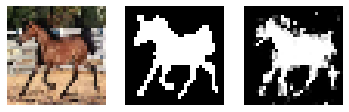

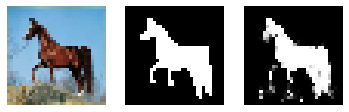

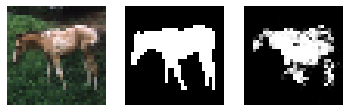


valid iou_score %: 61.27


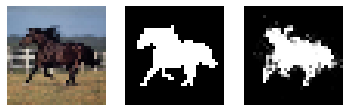

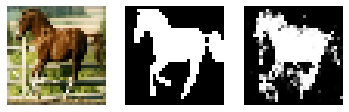

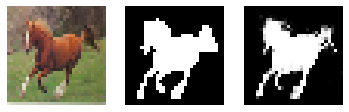

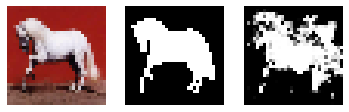

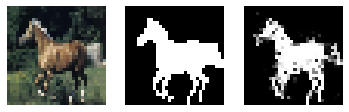

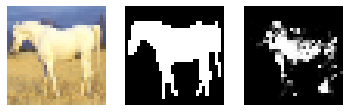

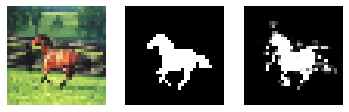

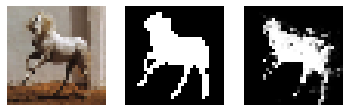

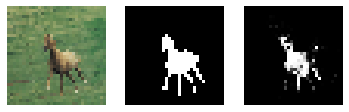

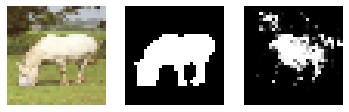

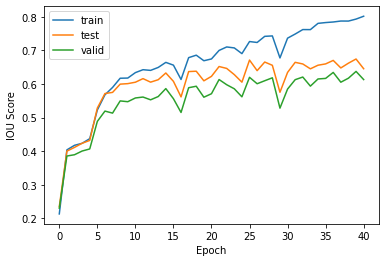

PT Gen Loss: 0.18323421478271484, Gen Loss: -115.09810638427734, Dis Loss: 10.026838302612305, Adv Loss: 10.026838302612305

epoch: 41
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.1790274828672409, Gen Loss: -113.79490661621094, Dis Loss: 10.042600631713867, Adv Loss: 10.042600631713867

epoch: 42
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.1672137826681137, Gen Loss: -112.27851867675781, Dis Loss: 10.039224624633789, Adv Loss: 10.039224624633789

epoch: 43
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.15295347571372986, Gen Loss: -111.44632720947266, Dis Loss: 10.031217575073242, Adv Los

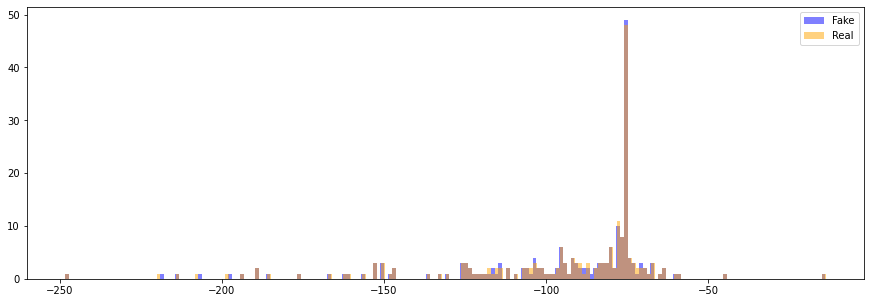


train iou_score %: 90.35


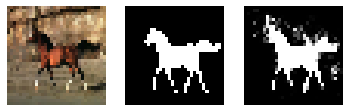

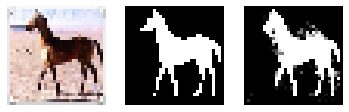

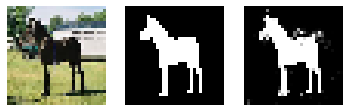

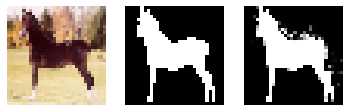

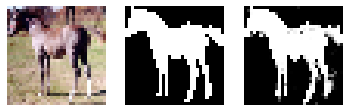

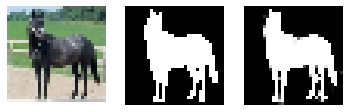

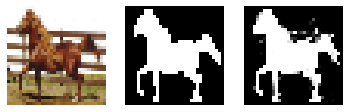

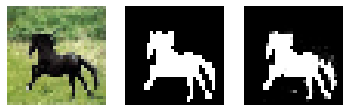

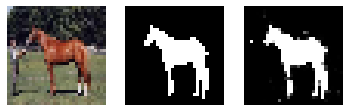

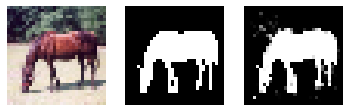


test iou_score %: 67.19


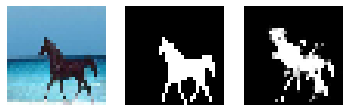

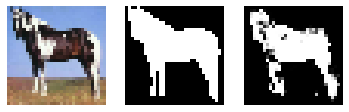

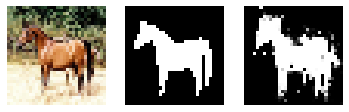

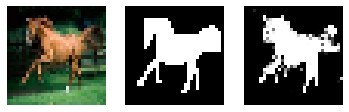

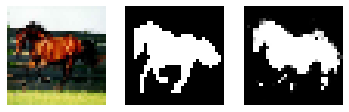

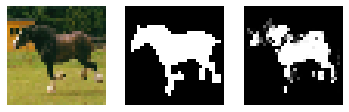

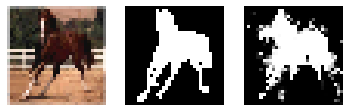

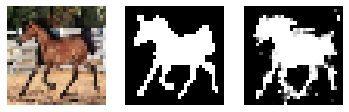

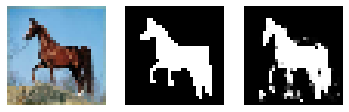

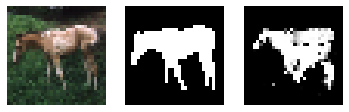


valid iou_score %: 64.22


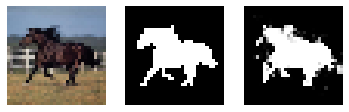

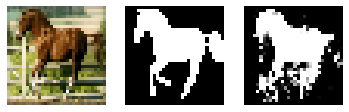

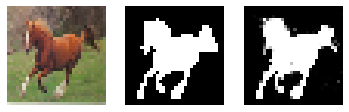

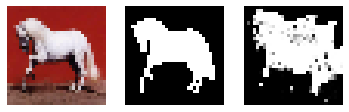

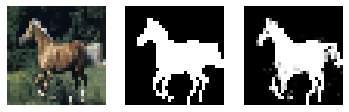

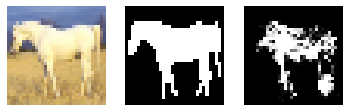

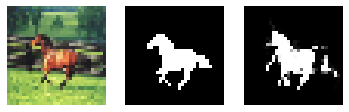

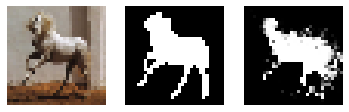

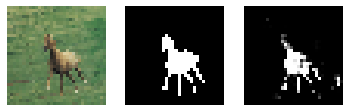

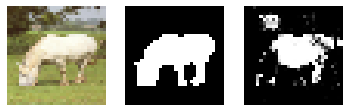

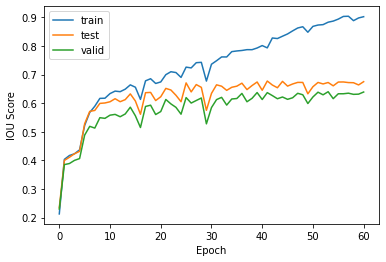

PT Gen Loss: 0.08820293843746185, Gen Loss: -91.62777709960938, Dis Loss: 10.014470100402832, Adv Loss: 10.014470100402832

epoch: 61
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.08254880458116531, Gen Loss: -90.59214782714844, Dis Loss: 10.017928123474121, Adv Loss: 10.017928123474121

epoch: 62
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.07566993683576584, Gen Loss: -90.12557983398438, Dis Loss: 10.018682479858398, Adv Loss: 10.018682479858398

epoch: 63
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.07248672097921371, Gen Loss: -89.35414123535156, Dis Loss: 10.015009880065918, Adv Loss:

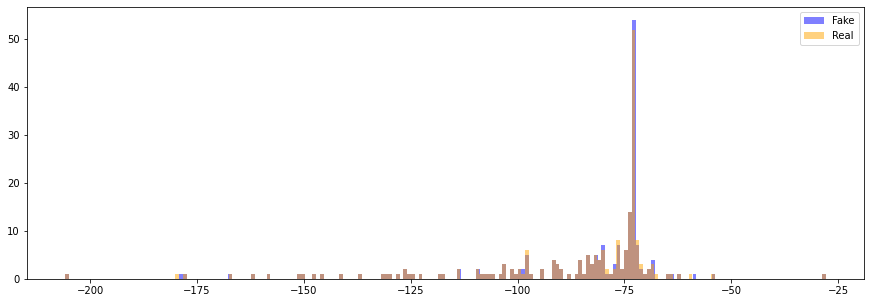


train iou_score %: 94.8


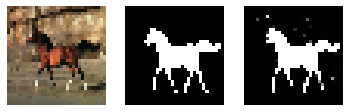

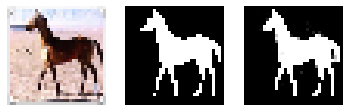

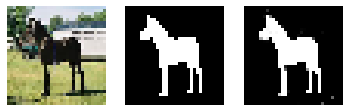

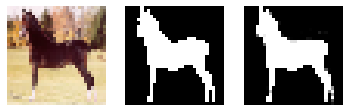

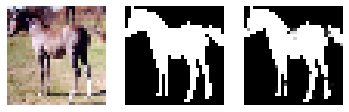

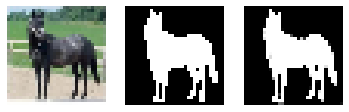

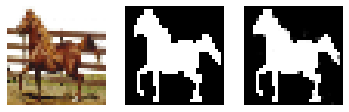

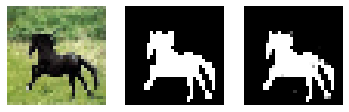

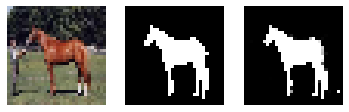

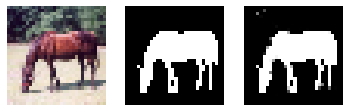


test iou_score %: 66.18


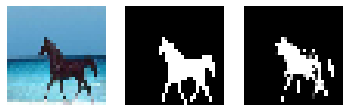

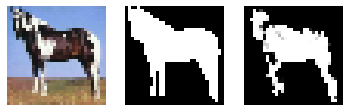

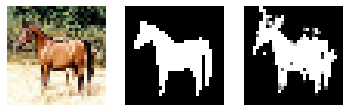

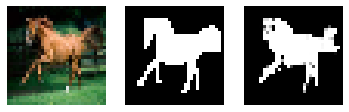

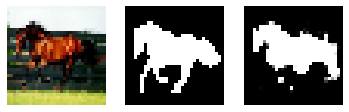

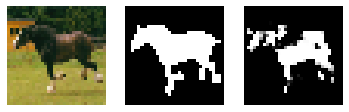

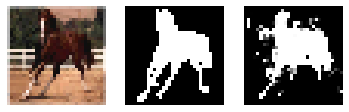

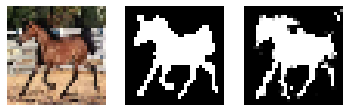

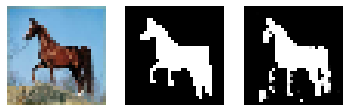

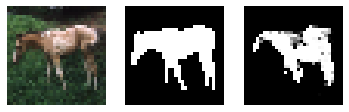


valid iou_score %: 62.55


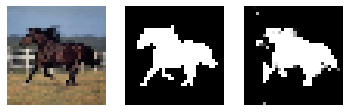

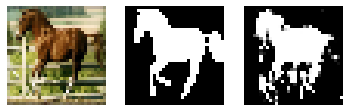

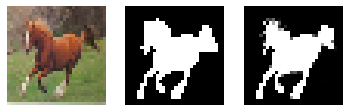

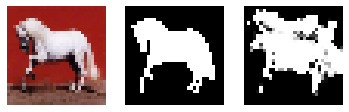

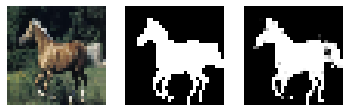

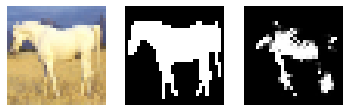

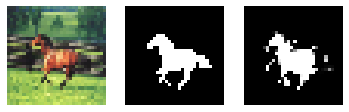

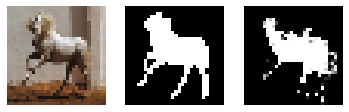

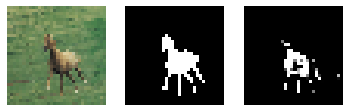

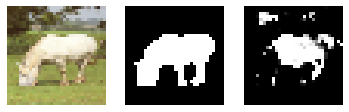

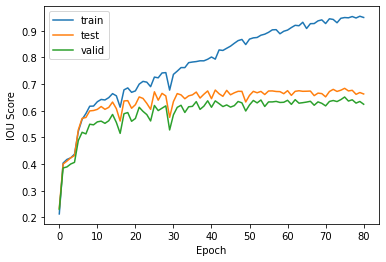

PT Gen Loss: 0.04234341159462929, Gen Loss: -82.40489196777344, Dis Loss: 10.004676818847656, Adv Loss: 10.004676818847656

epoch: 81
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.04693657159805298, Gen Loss: -81.9637680053711, Dis Loss: 10.006599426269531, Adv Loss: 10.006599426269531

epoch: 82
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.047578804194927216, Gen Loss: -81.81428527832031, Dis Loss: 10.006634712219238, Adv Loss: 10.006634712219238

epoch: 83
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
PT Gen Loss: 0.04416204243898392, Gen Loss: -81.60370635986328, Dis Loss: 10.002004623413086, Adv Loss:

In [12]:
# general
batch_size = 10
n_epoch = 100
n_figs = 10

# disc
n_update_dis = 1
d_learning_rate = 0.0003

# pretrain gen
alpha = 0.01
pt_gen = True
pt_g_learning_rate = 0.001

# ebm gen
inf_iter = 5 #alpha
inf_rate = 2 #delta
g_learning_rate = 0.0003

##############################################################################################################

# create tf dataset generator object
N = len(xdata)
train_dataset = tf.data.Dataset.from_tensor_slices((xdata, ydata))
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=False)

# Initialize Networks
gen = Generator()
dis = Discriminator()

# Initialize Optimizer
gen_opt = tf.keras.optimizers.Adam(g_learning_rate)
gen_opt_pt = tf.keras.optimizers.Adam(pt_g_learning_rate)
dis_opt = tf.keras.optimizers.Adam(d_learning_rate)

# Initialize Metrics
adv_loss = tf.keras.metrics.Mean(name = 'Adversarial_Loss')
dis_loss = tf.keras.metrics.Mean(name = 'Discriminator_Loss')
gen_loss = tf.keras.metrics.Mean(name = 'Generator_Loss')
gen_pretrain_loss = tf.keras.metrics.Mean(name = 'Generator_Pretrain_Loss')

train(train_dataset, n_epoch, n_update_dis, inf_iter, inf_rate, pt_gen, alpha)